# Fine Tuning / Transfer learning of ViT model
Use case: classifier Lego/Duplo

In [35]:
from collections import defaultdict
import imageio.v2 as iio
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras as ks
from time import strftime
from transformers import ViTImageProcessor, TFViTModel

In [33]:
# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

# initiate tensorboard
%load_ext tensorboard

# Define function to generate subdirectory names to store logs of tensorboard
def dir_logs(parent_dir='tf_log'):
    '''Function takes a parent directory path and adds a subdirectory composed of the current date and time.
    This is useful for Tensorboard logs, so logs of different training runs are stored in different
    directories.
    Parameters:
        parent_dir <str> name of the parent directory
    
    Returns:
        <file path object> directory containing current date and time'''
    return Path(parent_dir) / strftime('%Y_%m_%d_%H_%M_%S')

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Load pretrained model and corresponding ImageProcessor

In [16]:
# Create an instance of ViTImageProcessor and use ViT base model as pretrained model
vit_preprocessor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
# Create an instance of ViTForImageClassification and use ViT base model as pretrained model
vit_base_model = TFViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


## Sublcass of keras.Model
Create a model class containing the  pretrained ViT and a dense classifier on top of pooler layer of ViT

In [3]:
class ViTLegoDuplo(tf.keras.Model):
    '''Image transformer class is intended to be constructed on a ViT model containing a 
    pooler layer.
    A dense layer is added on top of the ViT pooler. In case of a use as a binary classifier, 
    the outputs will be logits from one neuron. In case of a one-hot-encoded classification
    task, the output will be probabilities from a Softmax-function. See __init__() for details.

    A method is provided to declare different layersr of the ViT model as trainable (see
    ".choose_trainables()"" for details).
    '''
    def __init__(self, vit_base_model, no_classes='binary'):
        # vit_base_model should be a ViT model with pretrained pooler layer
        # no_classes: Pass "binary" to obtain a single neuron output, providing logits
        #     Pass: integer number of classes for one-hot-encoded data, layer provides
        #     probabilties from Softmax-function in this case
        super().__init__()
        self.vit = vit_base_model
        if no_classes == 'binary':
            self.dense_layer = tf.keras.layers.Dense(1, activation='tanh')
        else:
            self.dense_layer = tf.keras.layers.Dense(no_classes, activation='tanh')
            self.dense_layer = tf.keras.layers.Softmax()

    def choose_trainables(self, embeddings=True, encoder=True, layernorm=True, pooler=True):
        # Method to set trainable argument of components of ViT model.
        
        # Access embedding layer of ViT model in its mainlayer and set trainable parameter
        self.vit.layers[0].embeddings.trainable = embeddings
        # Access encoder layers of ViT model in its mainlayer and set trainable parameter
        self.vit.layers[0].encoder.trainable = encoder
        # Access layer normalization of ViT model in its mainlayer and set trainable parameter
        self.vit.layers[0].layernorm.trainable = layernorm
        # Access pooler of ViT model in its mainlayer and set trainable parameter
        self.vit.layers[0].pooler.trainable = pooler

    def call(self, x):
        x = self.vit(x)[1] # take only output of pooler
        return self.dense_layer(x)    

## Instantiate model for Lego/Duplo problem

In [4]:
# Instantiate model from ViTLegoDuplo class and define trainable argument for components of ViT model
classifier = ViTLegoDuplo(vit_base_model) # for binary classification
classifier.choose_trainables(embeddings=False, encoder=False, layernorm=False, pooler=False)    
# Define appropriate loss, compile and build model.
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
classifier.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
classifier.build(input_shape=(None, 3, 224, 224))
classifier.summary(expand_nested=True)

Model: "vi_t_lego_duplo"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  769       
                                                                 
Total params: 86390017 (329.55 MB)
Trainable params: 769 (3.00 KB)
Non-trainable params: 86389248 (329.55 MB)
_________________________________________________________________


## Loading and basic preprocessing data
From pictures in directories

In [37]:
# List of directories with data to use in training, validation and testing
# One directory per class
datadir_list = [
    '/home/felbus/transformers/data/Lego', 
    '/home/felbus/transformers/data/Duplo'
]

# Definition of useful classes and functions for later Papeline creation

class ParseCat:
    '''Class helps to transform string labels to integer numbers. Therefore an initially
    empty dictionary is filled with an pair (categry_str: #), when class is called. 
    # is the integer representation of a category string value and is generated automatically,
    when class is called with an unknown category string value. Class returns # uppon call.
    '''
    def __init__(self):
        self.cat_dict = {} # emtpy dictionary to hold ('category': #) pairs

    def __call__(self, category):
        # Dynamically define #, if category is unkwown, return #
        if (cat_int := self.cat_dict.get(category)) is None: 
            self.cat_dict[category] = cat_int = len(self.cat_dict) 
        return cat_int # return #:            

    def reverse_dict(self):
        # Returns dictionary, that allows look-up from hashes to cateogry_str
        reverse_dict = {} # empty dictionary to fill with pairs ('#': category_str)
        for (cat_str, hashtag) in self.cat_dict.items():
            if (val := reverse_dict.get(str(hashtag))) is None:
                val = reverse_dict[str(hashtag)] = cat_str
        return reverse_dict
    
    def __str__(self):
        # Generate human readable output for print()
        content_str = f'#\t\tCategory\n-------------------------------------\n'
        for i, (key, value) in enumerate(self.cat_dict.items()):
            content_str += f'{value}\t\t{key}\n'
        return content_str
        

@tf.py_function(Tout=tf.float32)
def apply_feature_extractor(x):
    '''Function will apply "feature_extractor" to image data. Decorator allows usage of this function inside tf.data.Dataset.map().
    Parameters:
    x <tf.Tensor>: image data

    Return:
    <tf.Tensor>: features of image data with shape (channels, heigth, width)
    '''
    return vit_preprocessor.preprocess(images=x, return_tensors='tf')['pixel_values']

def list_file_generator(dir_list):
    '''Generator function will take a list with directory paths and yield tuples
    of two strings (filepath, label). Label will be extracted from lowest part of
    directory path and is pared to an integer category number.
    Parameters:
    dir_list <list <str>>: list of strings containing paths to directories

    Return:
    <tuple (<str>, <int>): Tuple containing absolute file path and label category
    '''
    # Loop over all directories passed in dir_list
    for directory in dir_list:
        # Decode bytestring to string
        directory = directory.decode('utf-8')
        # Take lowest directory name as label and parse it to integer
        _, label_str = os.path.split(directory)
        label = lego_parse(label_str)
        # Create list of all files in directory and loop over these files
        file_list = os.listdir(directory)
        for file in file_list:
            # join path and filename to absolute file path of this file
            file_path = os.path.join(directory, file)
            # yield tupel (absolute file path to image file, label)
            yield file_path, label
            
def load_image_data(path):
    '''Function will load image data and process it with tensorflow decode_image function.
    Parameters:
    path <str>: file path string to load the image from

    Return:
    <tf.Tensor>: Decoded image with shape (height, width, channels)
    '''
    image = tf.io.read_file(path)
    return tf.io.decode_image(image, channels=3)

# Creation of Pipeline object tf.data.Dataset

# Instantiate a perser object for label management
lego_parse = ParseCat()

# Initiate an tf.data.Dataset instance from generator function. 
# Elements will be of type tuple with two Tensors (file path and integer label)
image_dataset = tf.data.Dataset.from_generator(
    list_file_generator, args=[datadir_list], output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string), # file path
        tf.TensorSpec(shape=(), dtype=tf.int16) # label category
    )
)

# Shuffle tf.data.Dataset before images are loaded, to avoid big data in RAM
image_dataset = image_dataset.shuffle(1000, reshuffle_each_iteration=False)

# Load image data by mapping file path to load_image_data function
image_dataset = image_dataset.map(lambda x, y: (load_image_data(x), y))

# Wrap call of ViTImageProcessor in batch() / unbatch(), because otherwise it will add a dimension, that is not
# recognized as a batching dimension by the tf.data.Dataset instance.
image_dataset = image_dataset.batch(2)
# Apply feature_extractor to all image data, data in pipeline will be "channel dimension first"
# Images will be rescaled to [0, 1] and then normalized to means [0.5, 0.5, 0.5], resized to 3x224x224
image_dataset = image_dataset.map(lambda x, y: (apply_feature_extractor(x), y))
image_dataset = image_dataset.unbatch()

# Create new dataset from iterator over image_dataset. This is a work-around, as the
# return of ViTImageProcessor somehow returns a Dataset, that is unsuitable to be 
# passed to Model. Most probably because of missing Tensor Shape information
image_dataset = tf.data.Dataset.from_generator(
    image_dataset.__iter__, output_signature=(
        tf.TensorSpec(shape=(3, 224, 224), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int16)
    )
)

# Batching 
image_dataset = image_dataset.batch(32)

## Creation of test dataset

In [45]:
datadir_list_test = [
    '/home/felbus/transformers/data/Test_data/Duplo'
]

image_dataset_test = tf.data.Dataset.from_generator(
    list_file_generator, args=[datadir_list_test], output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string), # file path
        tf.TensorSpec(shape=(), dtype=tf.int16) # label category
    )
)

image_dataset_test = image_dataset_test.map(lambda x, y: (load_image_data(x), y))

image_dataset_test = image_dataset_test.batch(2)
# Apply feature_extractor to all image data, data in pipeline will be "channel dimension first"
# Images will be rescaled to [0, 1] and then normalized to means [0.5, 0.5, 0.5], resized to 3x224x224
image_dataset_test = image_dataset_test.map(lambda x, y: (apply_feature_extractor(x), y))
image_dataset_test = image_dataset_test.unbatch()

# Create new dataset from iterator over image_dataset. This is a work-around, as the
# return of ViTImageProcessor somehow returns a Dataset, that is unsuitable to be 
# passed to Model. Most probably because of missing Tensor Shape information
image_dataset_test = tf.data.Dataset.from_generator(
    image_dataset_test.__iter__, output_signature=(
        tf.TensorSpec(shape=(3, 224, 224), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int16)
    )
)

# Batching
image_dataset_test = image_dataset_test.batch(100)

## Data inspection
By vizualization of examples

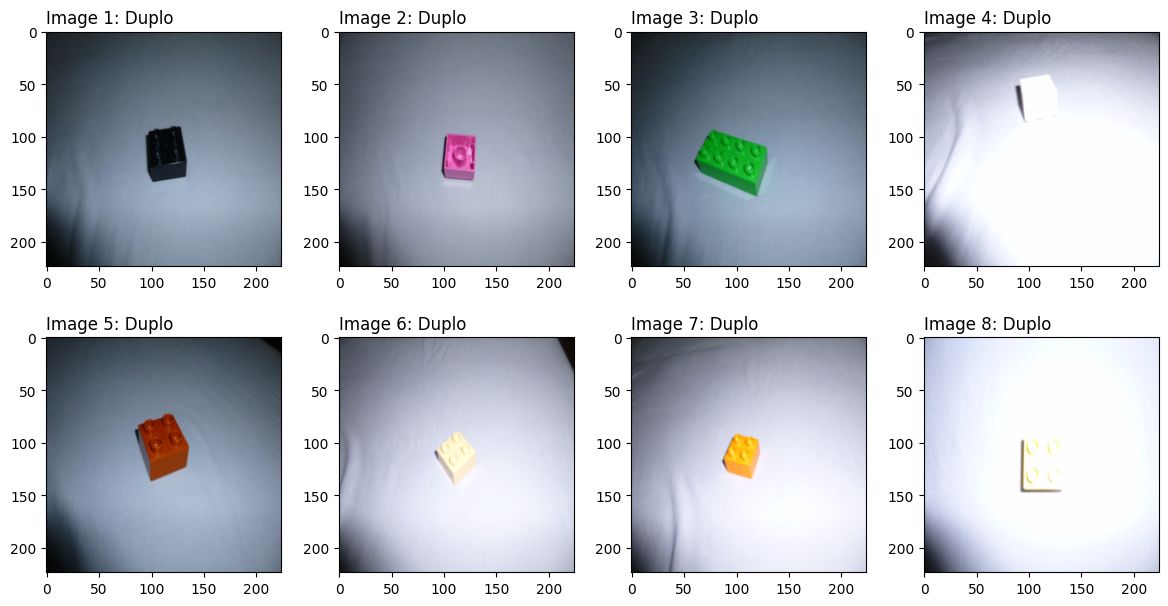

In [46]:
def plot_images(data, label_dict, num_images=4):
    '''Function will plot images and print label in title. The tf.data.Dataset
    passed as "data" to function is expected to be already iterated over. This
    function will not cuase a first iteration over Dataset, to avoid lengthly 
    execution times. To iterate once call this piece of code for example
    "for val in data:
        pass"
    Parameters:
    data <tf.data.Dataset> containing tuples of 
        (<tf.tensor, shape=(3, 224, 224, dtype=float>), cat <int>) 
        image data in tf.tensor is expected to be scaled to [-1, 1]
    label_dict <dictionary> containing as keys: string of integer category of
        labels in "data" and as values: string description of category
    num_images <int> Number of images to plot from data    
    '''
    # unbatch, so later can be iterated over single instances
    data = data.unbatch()
    # Change from channel-first to channel-last representation of images, as
    # matplotlib requires this representation
    data = data.map(lambda x, y: (tf.transpose(x, perm=[1, 2, 0]), y))
    # Rescaling pixel values from [-1, 1] to [0, 1], because matplotlib will clip
    # negatives otherwise.
    data = data.map(lambda x, y: ((x + 1)/2, y))
    # Calculate nrows (how many rows of subplots in figure) from num_samples
    # 4 images in each column is fixed
    if (num_images%4) == 0:
        nrows = num_images // 4
    else:
        nrows = num_images // 4 + 1
    # Create figure and axes of subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=4, figsize=(12, 3*nrows))
    # For nice layout.
    fig.tight_layout(h_pad=3, w_pad=0)
    # Iterate over axes and instances in data
    for i, (axis, instance) in enumerate(zip(axes.flat, data)):
        # Plot image, only if number of plotted images doesn't exceed num_images
        if i < num_images:
            # try plotting of image. If fails raise exception indicating too many
            # images requested from data
            try:
                # Look-up of string category description of label from label_dict
                label = label_dict[str(instance[1].numpy())]
                # Create title for subplot with number of image in plot and label
                axis.set_title(f'Image {i+1}: {label}', loc='left')
                # Plot image of this iteration in subplot
                axis.imshow(instance[0])
            except:
                raise Exception(IndexError, 'More images to plot than in obtained in data')
        else:
            # If already all  requested images are plotted, plot blank white in subplot
            axis.imshow(tf.constant(1, shape=(224, 224, 3)))

# Call plot_image on labeled and preprocessed dataset
plot_images(image_dataset_test, label_dict=lego_parse.reverse_dict(), num_images=8)

## Training the classifier
On Lego/Duplo classifying problem

In [38]:
log_directory = dir_logs()
callback_tensorboard = tf.keras.callbacks.TensorBoard(log_directory, histogram_freq=10)

classifier.fit(image_dataset, epochs=10, callbacks=[callback_tensorboard])

Epoch 1/10
7/7 [==============================] - 102s 13s/step - loss: 0.8339 - accuracy: 0.4619
Epoch 2/10
7/7 [==============================] - 91s 12s/step - loss: 0.8088 - accuracy: 0.4619
Epoch 3/10
7/7 [==============================] - 93s 12s/step - loss: 0.6997 - accuracy: 0.4670
Epoch 4/10
7/7 [==============================] - 91s 12s/step - loss: 0.5820 - accuracy: 0.6904
Epoch 5/10
7/7 [==============================] - 90s 12s/step - loss: 0.5423 - accuracy: 0.8477
Epoch 6/10
7/7 [==============================] - 88s 11s/step - loss: 0.5010 - accuracy: 0.6853
Epoch 7/10
7/7 [==============================] - 89s 11s/step - loss: 0.4764 - accuracy: 0.7462
Epoch 8/10
7/7 [==============================] - 90s 12s/step - loss: 0.4546 - accuracy: 0.8782
Epoch 9/10
7/7 [==============================] - 90s 12s/step - loss: 0.4394 - accuracy: 0.8832
Epoch 10/10
7/7 [==============================] - 84s 11s/step - loss: 0.4276 - accuracy: 0.8832


#### Show training in tensorboard

In [39]:
%tensorboard --logdir tf_log

In [47]:
classifier.evaluate(image_dataset_test)

1/1 [==============================] - 18s 18s/step - loss: 0.8510 - accuracy: 0.0750


[0.8510330319404602, 0.07500000298023224]

In [43]:
for val in image_dataset_test.unbatch():
    print(val[0].shape)

(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
